In [1]:
import sys
import os
import itertools
import pandas as pd
from PIL import Image
import numpy as np
from numpy import *
import csv
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from os import walk

import seaborn as sns
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv3D # to add convolutional layers
from keras.layers.convolutional import MaxPooling3D # to add pooling layers
from keras.layers import Flatten # to flatten data for fully connected layers
from keras.layers import Dropout # to avoid overfitting
from keras.layers import Activation

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['val_loss'][-1]
    acc = history.history['val_acc'][-1]
    plt.title('Validation Loss: %.3f, Validation Accuracy: %.3f' % (loss, acc))

In [4]:
"""
def view_images(folder):
    images = os.listdir(folder)
    for i in range(0, 5):
        data = image.imread(folder + '\\' + images[i])
        # summarize shape of the pixel array
        print(data.dtype)
        print(data.shape)
        # display the array of pixels as an image
        pyplot.imshow(data)
        pyplot.show()
        
def view_images(folder):
    images = os.listdir(folder)
    for i in range(0, 1):
        temp = asarray(Image.open(os.path.join(folder, images[i])))
        x = temp.shape[0]
        y = temp.shape[1]*temp.shape[2]
        temp.resize((x,y)) # a 2D array
        #print(x,y)
        #print(temp)
"""

"\ndef view_images(folder):\n    images = os.listdir(folder)\n    for i in range(0, 5):\n        data = image.imread(folder + '\\' + images[i])\n        # summarize shape of the pixel array\n        print(data.dtype)\n        print(data.shape)\n        # display the array of pixels as an image\n        pyplot.imshow(data)\n        pyplot.show()\n        \ndef view_images(folder):\n    images = os.listdir(folder)\n    for i in range(0, 1):\n        temp = asarray(Image.open(os.path.join(folder, images[i])))\n        x = temp.shape[0]\n        y = temp.shape[1]*temp.shape[2]\n        temp.resize((x,y)) # a 2D array\n        #print(x,y)\n        #print(temp)\n"

In [5]:
def load_train_images(folder):
    train_pixels = {}
    images = os.listdir(folder)
    for i in range(0, len(images)):
        key = int(images[i].split('.')[0])
        img = Image.open(os.path.join(folder, images[i]))
        data = np.asarray(img)
        train_pixels.update({key : data.flatten().tolist()})
    train_pixel = pd.DataFrame.from_dict(train_pixels, orient = 'index')
    train_pixel['id'] = train_pixel.index
    train_col = []
    for i in range(1, train_pixel.shape[1]):
        train_col.append('pixel_' + str(i))
    train_col.append('id')
    train_pixel.columns = train_col
    train_val = pd.read_csv('train.csv', index_col = 0)
    train_data = train_pixel.merge(train_val, left_on = 'id', right_on = 'id')
    return train_data

def load_test_images(folder):
    test_pixels = {}
    images = os.listdir(folder)
    for i in range(0, len(images)):
        key = int(images[i].split('.')[0])
        img = Image.open(os.path.join(folder, images[i]))
        data = np.asarray(img)
        test_pixels.update({key : data.flatten().tolist()})
    test_pixel = pd.DataFrame.from_dict(test_pixels, orient = 'index')
    test_pixel['id'] = test_pixel.index
    test_col = []
    for i in range(1, test_pixel.shape[1]):
        test_col.append('pixel_' + str(i))
    test_col.append('index')
    test_pixel.columns = test_col
    return test_pixel

In [6]:
# view_images('C:\\Users\\ak19919\\Downloads\\Github\\Analytics-Vidya\\Apparels\\test')
train_df = load_train_images('C:\\Users\\ak19919\\Downloads\\Github\\Analytics-Vidya\\Apparels\\train')
test_df = load_test_images('C:\\Users\\ak19919\\Downloads\\Github\\Analytics-Vidya\\Apparels\\test')

In [7]:
train_df = train_df.drop(['id'], axis = 1)
train_df.head()

,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_3128,pixel_3129,pixel_3130,pixel_3131,pixel_3132,pixel_3133,pixel_3134,pixel_3135,pixel_3136,label
0,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,9
1,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,5
2,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,8
3,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,8
4,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,6


In [8]:
test_df.head()

,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_3128,pixel_3129,pixel_3130,pixel_3131,pixel_3132,pixel_3133,pixel_3134,pixel_3135,pixel_3136,index
60001,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,60001
60002,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,60002
60003,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,60003
60004,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,60004
60005,0,0,0,255,0,0,0,255,0,0,...,255,0,0,0,255,0,0,0,255,60005


In [9]:
columns = train_df.columns
X = train_df[columns[columns != 'label']]
y = train_df['label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [11]:
X_train.shape

(48000, 3136)

In [12]:
X_test.shape

(12000, 3136)

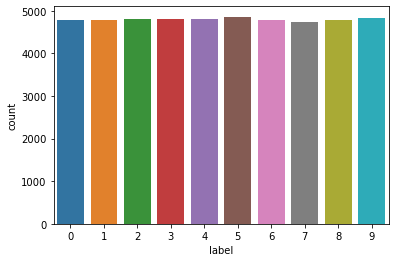

In [13]:
sns.countplot(y_train)

In [14]:
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 4).astype('float32')
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 4).astype('float32')

In [15]:
X_train = X_train / 255 # normalize training data
X_test = X_test / 255 # normalize test data

In [16]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1] # number of categories

In [17]:
def convolutional_model():
    ADAMAX = optimizers.Adamax(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999)
    # create model
    model = Sequential()
    model.add(Conv3D(32, (4, 4, 4), activation = 'relu', input_shape = (28, 28, 4), kernel_initializer='he_uniform'))
    model.add(Conv3D(64, (3, 3, 3), activation = 'relu'))
    model.add(MaxPooling3D(pool_size = (2, 2), strides = (2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))
    
    model.add(Conv3D(128, (3, 3, 3), activation = 'relu'))
    model.add(Conv3D(256, (3, 3, 3), activation = 'relu'))
    model.add(MaxPooling3D(pool_size = (2, 2), strides = (2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))

    model.add(Conv3D(256, (2, 2, 2), activation = 'relu'))
    model.add(MaxPooling3D(pool_size = (2, 2, 2), strides = (2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    # Compile model
    model.compile(optimizer = ADAMAX, loss = 'categorical_crossentropy',  metrics = ['accuracy'])
    return model

In [18]:
gen = ImageDataGenerator(rotation_range = 10, width_shift_range = 0.1, shear_range = 0.1,
                         height_shift_range = 0.1, zoom_range = 0.1, fill_mode = 'nearest', horizontal_flip = False,
                         vertical_flip = False, featurewise_center = False,
                         samplewise_center = False, featurewise_std_normalization = False,
                         samplewise_std_normalization = False)
test_gen = ImageDataGenerator()

# Create batches to  train models faster
train_generator = gen.flow(X_train, y_train, batch_size = 32)
test_generator = test_gen.flow(X_test, y_test, batch_size = 32)

In [19]:
# Use annelar to gradually decrese the learning rate to improve generalization

reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00002,
                                            mode = 'auto', cooldown = 0)

In [20]:
# build the model
model = convolutional_model()
epochs = 32
# fit the model

#history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 200, verbose = 2)

history = model.fit_generator(train_generator, steps_per_epoch = 48000//16, epochs = epochs, 
                              validation_data = test_generator, validation_steps = 12000//16, verbose = 1,
                              callbacks=[reduce_lr])

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))
plot_loss_accuracy(history)

ValueError: Input 0 is incompatible with layer conv3d_1: expected ndim=5, found ndim=4

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
Y_true = np.argmax(y_test, axis = 1)
cm = confusion_matrix(Y_true, y_pred)
plot_confusion_matrix(cm, classes = range(10))

In [ ]:
test_data = test_df.values.reshape(test_df.shape[0], 28, 28, 4).astype('float32')
test_data = test_data / 255
Y_pred = model.predict(test_data)

In [ ]:
Y_pred = np.argmax(Y_pred,axis = 1)
Y_pred = pd.Series(Y_pred, name = "Label")

In [ ]:
submission_df = pd.DataFrame({
                  "id": pd.Series(range(60001, len(Y_pred)+1)),
                  "label": pd.Series(Y_pred)})

In [ ]:
submission_df.to_csv('submission_1.csv', index = False)